# 6. Putting it all together

We have come a long way from our first notebook. We have trained a network to recognize digits. We have understood the limitations of **_fully connected_** networks in the number of weights they must learn for image tasks. We have looked at convolutions and how they need to learn far fewer weights for image tasks.

In this section, we will look at constructing a full convolutional network for MNIST digit recognition.

As usual we start with a little initialization:

In [1]:
# Initialization stuff
!gdown https://drive.google.com/uc?id=1LJccUzmjbD_tJ5TF3J3CkkeDNeItElLd
!unzip cgML.zip
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable 
import PIL.Image as PILImage
from PIL import ImageFilter
import cv2
from scripts.helper import *
plt.style.use('ggplot')

# For reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

Downloading...
From: https://drive.google.com/uc?id=1LJccUzmjbD_tJ5TF3J3CkkeDNeItElLd
To: /content/cgML.zip
35.4MB [00:00, 113MB/s] 
Archive:  cgML.zip
replace scripts/helper.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: scripts/helper.py       
  inflating: scripts/__pycache__/helper.cpython-37.pyc  
  inflating: .ipynb_checkpoints/1 - Facial Landmarks-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/1- Introduction - What is Machine Learning anyway_-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/2 - Automatic Learning-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/3 - A little inspiration from our brain-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/4 - Let's get visual!-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/5 - It ain't convoluted!-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/6 - Putting it all together-checkpoint.ipynb  
  inflating: datasets/MNIST/processed/test.pt  
  inflating: datasets/MNIST/processed/training.pt  
  inflating: datase

### What does a CNN learn?

When we discussed **_fully connected_** networks, we see how a single artificial neuron **_"learns"_** the importance of an input **_"signal"_** through the assigning a weight.

What does a CNN learn?

To answer this question, first let's look at a picture:

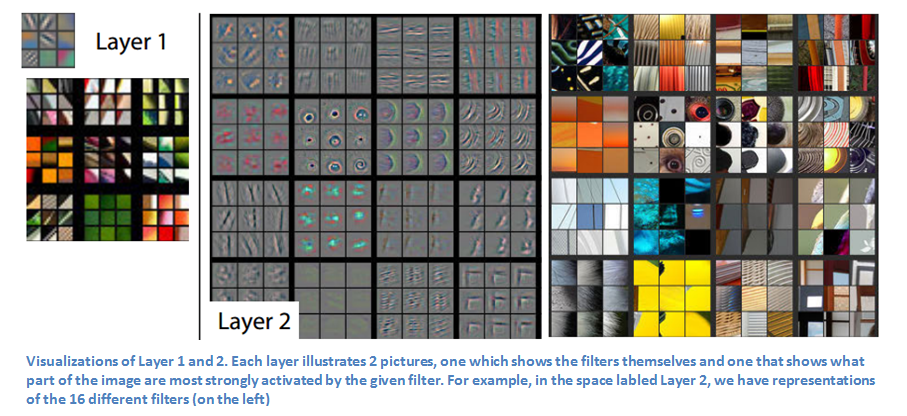

In [2]:
Image("images/deconvnet.png")

Source: [Adesh Pande's blog](https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html)

The picture above shows how the early layers of the network learn filters (or kernels) that are maximally activated by simple features such as edges. When these kernels are placed upon an area of image that contains the pattern the kernel has learned to "**_amplify_**" (be maximally activated on), the result in that area of the output is strong.

This is why the network starts of with a shallower convolutional volume in the z dimension, and progressively reduces the x, y dimensions while learning more **_filters_** (increase in z dimension) in the later layers.

These small filters in the later layers are maximally activated by larger concepts than an edge or a line. They could be activated on an eye, or an ear etc. The CNN is essentially learning a **_visual heirarchy of concepts_**.

Pooling is a technique that is used to further boost these signals and reduce the volume in the x, and y dimensions.

### Pooling

The two most common forms of pooling are max pooling and avg pooling. A pooling operation, like a convolution operates in a sliding window fashion over the input in the x, y direction (but, like a convolution, can act on a 3d volume as well).

To illustrate this, consider the following image:

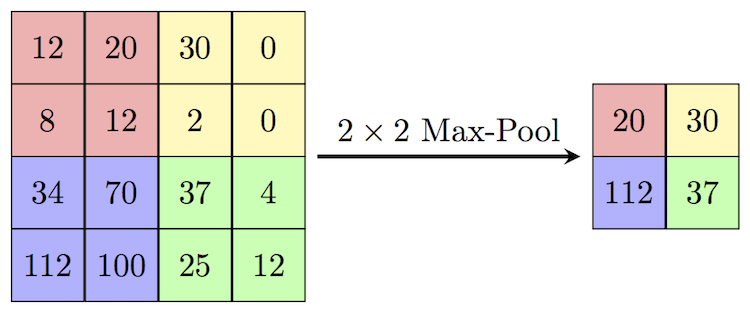

In [3]:
Image("images/max-pooling.png")

In the example above, a 2x2 max pooling operation in applied with a stride of 2. The output is simply the maximum of the values where the pooling matrix is placed.

**Note:** Unlike a convolution which has weights, a pooling operation has no weights. It is simply aggregating or discretizing features.

In the case of average pooling, the operation results in an average of all the values where the pooling matrix is placed.

In the case of 3d volumes, the same operation occurs along every slice in the 3d volume.

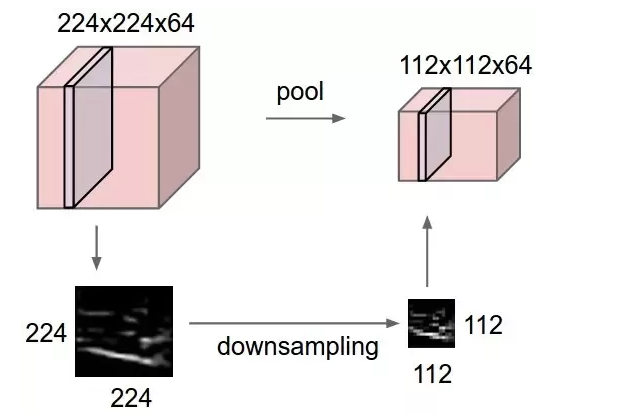

In [4]:
Image("images/max-pooling-volume.png")

### Let's build a CNN!

Now that you know the concepts, we can get back to our MNIST digit recognition problem.

The number of batches in one epoch over the training set is 600
The number of batches in one epoch over the test set is 100


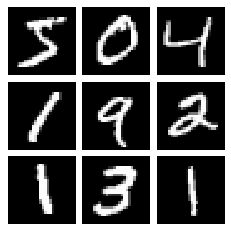

In [5]:
# Let's load up our dataset
# if it does not exist, download mnist dataset
root = "datasets"
train_set = datasets.MNIST(root=root, train=True, transform=None, download=True)
# We keep a copy of the dataset as is for visualization purposes
train_set_viz = datasets.MNIST(root=root, train=True, transform=None, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=None, download=True)
# We keep a copy of the dataset as is for visualization purposes
test_set_viz = datasets.MNIST(root=root, train=False, transform=None, download=True)
# Let's look at 9 images
im_list = [train_set[i][0] for i in range(9)]

batch_size = 100

# We want to transform each image to a tensor and perform some normalization
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set.transform = trans
test_set.transform = trans

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print("The number of batches in one epoch over the training set is {}".format(len(train_loader)))
print("The number of batches in one epoch over the test set is {}".format(len(test_loader)))

# Visualization
thumb_grid(im_list, (3, 3))

We will train the following network:

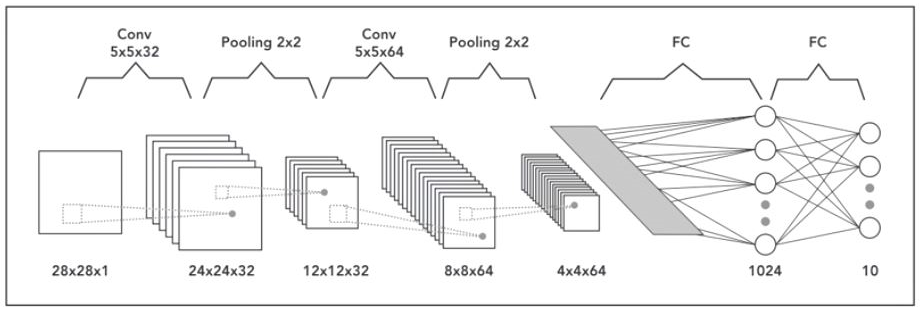

In [6]:
Image("images/cnn.png")

In [7]:
# This will flatten the input
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

# Instead of defining the model in one go, we will define it layer by layer to verify the output sizes
sample_image_pixels = np.array(im_list[0])
print("Raw input shape is {}".format(sample_image_pixels.shape))
# Let's add a dimension at the beginning (remember torch input is channels first)
sample_image_pixels = np.expand_dims(sample_image_pixels, axis=0)
print("Input shape after adding dimension for channels is {}".format(sample_image_pixels.shape))
# Since our network expects batches of images, we also want to add a dimension for the index of 
# the image in the batch
sample_image_pixels = np.expand_dims(sample_image_pixels, axis=0)
print("Input shape after adding dimension for batch index is {}".format(sample_image_pixels.shape))
# Next we need to convert this into a tensor
sample_input = Variable(torch.Tensor(sample_image_pixels))
print(sample_input.shape)

conv_1 = torch.nn.Conv2d(1, 32, (5, 5), stride=1, padding=0)
conv_1_sample_output = conv_1(sample_input)
print("Output from conv 1 has shape {}".format(conv_1_sample_output.shape))
pool_1 = torch.nn.MaxPool2d((2, 2), stride=2)
pool_1_sample_output = pool_1(conv_1_sample_output)
print("Output from pool 1 has shape {}".format(pool_1_sample_output.shape))
conv_2 = torch.nn.Conv2d(32, 64, (5, 5), stride=1, padding=0)
conv_2_sample_output = conv_2(pool_1_sample_output)
print("Output from conv 2 has shape {}".format(conv_2_sample_output.shape))
pool_2 = torch.nn.MaxPool2d((2, 2), stride=2)
pool_2_sample_output = pool_2(conv_2_sample_output)
print("Output from pool 2 has shape {}".format(pool_2_sample_output.shape))
flatten = Flatten()
flatten_output = flatten(pool_2_sample_output)
print("Output from flatten has shape {}".format(flatten_output.shape))
fc1 = torch.nn.Linear(1024, 1024)
fc1_output = fc1(flatten_output)
print("Output from fc1 has shape {}".format(fc1_output.shape))
fc2 = torch.nn.Linear(1024, 10)
fc2_output_sample = fc2(fc1_output)
print("Output from fc2 has shape {}".format(fc2_output_sample.shape))

Raw input shape is (28, 28)
Input shape after adding dimension for channels is (1, 28, 28)
Input shape after adding dimension for batch index is (1, 1, 28, 28)
torch.Size([1, 1, 28, 28])
Output from conv 1 has shape torch.Size([1, 32, 24, 24])
Output from pool 1 has shape torch.Size([1, 32, 12, 12])
Output from conv 2 has shape torch.Size([1, 64, 8, 8])
Output from pool 2 has shape torch.Size([1, 64, 4, 4])
Output from flatten has shape torch.Size([1, 1024])
Output from fc1 has shape torch.Size([1, 1024])
Output from fc2 has shape torch.Size([1, 10])


Great! Now we've seen how these layers stack up to represent the exact figure.

Next, let's defines the model from these layers and start training.

In [8]:
model = torch.nn.Sequential(
    conv_1,
    torch.nn.ReLU(),
    pool_1,
    conv_2,
    torch.nn.ReLU(),
    pool_2,
    flatten,
    fc1,
    torch.nn.ReLU(),
    fc2)

# As a last sanity check, let's look at the shape that this model produces on our sample input
sample_output = model(sample_input)
print("Output from model has shape {}".format(sample_output.shape))

Output from model has shape torch.Size([1, 10])


Ok. That was easy! Let's train our model like last time:

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(10):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        #if use_cuda:
        #    x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        # Use an exponentially weighted average for running loss value
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))

==>>> epoch: 0, batch index: 100, train loss: 0.537482
==>>> epoch: 0, batch index: 200, train loss: 0.211227
==>>> epoch: 0, batch index: 300, train loss: 0.151187
==>>> epoch: 0, batch index: 400, train loss: 0.122855
==>>> epoch: 0, batch index: 500, train loss: 0.101528
==>>> epoch: 0, batch index: 600, train loss: 0.082854
==>>> epoch: 1, batch index: 100, train loss: 0.067973
==>>> epoch: 1, batch index: 200, train loss: 0.102731
==>>> epoch: 1, batch index: 300, train loss: 0.044877
==>>> epoch: 1, batch index: 400, train loss: 0.057080
==>>> epoch: 1, batch index: 500, train loss: 0.063754
==>>> epoch: 1, batch index: 600, train loss: 0.077872
==>>> epoch: 2, batch index: 100, train loss: 0.058243
==>>> epoch: 2, batch index: 200, train loss: 0.053625
==>>> epoch: 2, batch index: 300, train loss: 0.048974
==>>> epoch: 2, batch index: 400, train loss: 0.047412
==>>> epoch: 2, batch index: 500, train loss: 0.041344
==>>> epoch: 2, batch index: 600, train loss: 0.049742
==>>> epoc

[[5 0 4]
 [1 9 2]
 [1 3 1]]


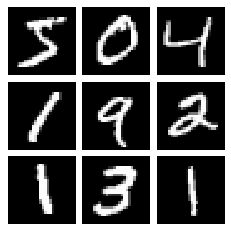

In [10]:
# Let's try our model on the first 9 rows of our training data
im_list = [train_set_viz[i][0] for i in range(9)]
thumb_grid(im_list, (3, 3))

predictor = MNISTPredictor(model)

outputs = []
for image in im_list:
    outputs.append(predictor(image))
    
# Just for display
output = np.array(outputs).reshape((3, 3))
print(output)

Let us now evaluate the model's accuracy on the validation data.

In [11]:
def print_accuracy():
    num_correct = 0
    num_wrong = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        x, target = Variable(x), target.detach().numpy()
        out = model(x).detach().numpy()
        for i in range(out.shape[0]):
            result = np.argmax(out[i])
            expected = target[i]
            if result == expected:
                num_correct += 1
            else:
                num_wrong += 1

    accuracy = num_correct / (num_correct + num_wrong)
    print("Model accuracy on test data is {}".format(accuracy))
print_accuracy()

Model accuracy on test data is 0.991


Yay! We trained a model with 99++ percent accuracy.

**Question**: How many parameters does our model have in the convolutional layers? How many parameters in the fully connected layers?

In [12]:
# Let's calculate the parameters (weights + bias terms of this network)
params_conv = 0
params_fc = 0
params_conv += np.prod(conv_1.weight.shape)
params_conv += np.prod(conv_1.bias.shape)
params_conv += np.prod(conv_2.weight.shape)
params_conv += np.prod(conv_2.bias.shape)
params_fc += np.prod(fc1.weight.shape)
params_fc += np.prod(fc1.bias.shape)
params_fc += np.prod(fc2.weight.shape)
params_fc += np.prod(fc2.bias.shape)
print("The model has {} parameters in convolutional layers".format(params_conv))
print("The model has {} parameters in fully connected layers".format(params_fc))

The model has 52096 parameters in convolutional layers
The model has 1059850 parameters in fully connected layers


**Question**: What happens if we remove one fully connected layer?

In [0]:
model = torch.nn.Sequential(
    conv_1,
    torch.nn.ReLU(),
    pool_1,
    conv_2,
    torch.nn.ReLU(),
    pool_2,
    flatten,
    #fc1,
    #torch.nn.ReLU(),
    fc2)

# As a last sanity check, let's look at the shape that this model produces on our sample input
sample_output = model(sample_input)
print("Output from model has shape {}".format(sample_output.shape))

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(10):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        #if use_cuda:
        #    x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        # Use an exponentially weighted average for running loss value
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))

Output from model has shape torch.Size([1, 10])
==>>> epoch: 0, batch index: 100, train loss: 0.114950
==>>> epoch: 0, batch index: 200, train loss: 0.083805
==>>> epoch: 0, batch index: 300, train loss: 0.082133
==>>> epoch: 0, batch index: 400, train loss: 0.066551
==>>> epoch: 0, batch index: 500, train loss: 0.063040
==>>> epoch: 0, batch index: 600, train loss: 0.061344
==>>> epoch: 1, batch index: 100, train loss: 0.036256
==>>> epoch: 1, batch index: 200, train loss: 0.059707
==>>> epoch: 1, batch index: 300, train loss: 0.030163
==>>> epoch: 1, batch index: 400, train loss: 0.045277
==>>> epoch: 1, batch index: 500, train loss: 0.040947
==>>> epoch: 1, batch index: 600, train loss: 0.043142
==>>> epoch: 2, batch index: 100, train loss: 0.039540
==>>> epoch: 2, batch index: 200, train loss: 0.034651
==>>> epoch: 2, batch index: 300, train loss: 0.028212
==>>> epoch: 2, batch index: 400, train loss: 0.035025
==>>> epoch: 2, batch index: 500, train loss: 0.025986
==>>> epoch: 2, b

In [0]:
print_accuracy()

# Let's calculate the parameters (weights + bias terms of this network)
params_conv = 0
params_fc = 0
params_conv += np.prod(conv_1.weight.shape)
params_conv += np.prod(conv_1.bias.shape)
params_conv += np.prod(conv_2.weight.shape)
params_conv += np.prod(conv_2.bias.shape)
#params_fc += np.prod(fc1.weight.shape)
#params_fc += np.prod(fc1.bias.shape)
params_fc += np.prod(fc2.weight.shape)
params_fc += np.prod(fc2.bias.shape)
print("The model has {} parameters in convolutional layers".format(params_conv))
print("The model has {} parameters in fully connected layers".format(params_fc))

Et voila! Now our model has less than 70,000 parameters compared to the half a million parameter model we trained using **_MLP_**.

It's an order of magnitude less parameters we need to learn!

## What just happened?

1. We started this section by understanding how a CNN learns through visual heirarchy.
2. We then looked at pooling as a means of downsampling and feature discretization operation that reduces convolutional volume in the x and y dimensions.
3. We then coded a **_deep CNN_** network while understanding step by step what the convolution layers and the pooling layers were doing to the convolutional volume.
4. We trained the CNN in exactly the same way that we trained our **_MLP_** network.
5. We achieved a higher accuracy.
6. We observed that a very large number of our models parameters lay in the fully connected layers.
7. We then removed just one fully connected layer to achieve only a slight degradation in accuracy as compared to the number of parameters in the network.
7. We observed that this network has an order of magnitude fewer parameters than the  **_MLP_** we trained earlier.

## What's next?

I hope you've enjoyed this workshop. I have tried to explain stuff so that you can see under the hood how machine learning is working rather than just learn how to use it.

By no means was my goal to provide a comprehensive crash course on this subject. Instead my goal was to show you that Machine Learning is not as abstract and hard as many people think.

I hope this workshop serves as a starting point of your journey into Machine Learning.

If you found this workshop interesting then I recommend you continue learning through the following two courses:

1. [Deep Learning Specialization on Coursera](https://www.coursera.org/specializations/deep-learning) (bottom up view)
2. [Fast.ai](https://course.fast.ai/) (top down view)

Having taken both of these, I recommend them both. Though you may encounter some repitition, going through both will cement your understanding of the subject.

Good luck and thank you!